LSTM으로 스팸메일 구분하기 

https://inuplace.tistory.com/547   


위의 블로그는 영어스팸메일을 구분하는 예제입니다. 이걸 금감원자료 15개와 일반상담자료 15개 총30개 샘플로 모델을 돌리는 중입니다. 

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# !mkdir -p '/content/drive/My Drive/test_colab'
# !ls -Fcal '/content/drive/My Drive/test_colab'
!ls '/content/drive/My Drive/test_colab'

ls: cannot access '/content/drive/My Drive/test_colab': No such file or directory


In [3]:
import numpy as np
import pandas as pd
!pip install git+https://github.com/ssut/py-hanspell.git
from hanspell import spell_checker


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-wq4rdlgg
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-wq4rdlgg
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4868 sha256=bff10308839a5732e167f3ccfca451a0b2925d29cd5df8b349a8adf8e69e43c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-nlzs26ux/wheels/ab/f5/7b/d4124bb329c905301baed80e2ae45aa14e824f62ebc3ec2cc4
Successfully built py-hanspell


In [4]:
import tensorflow as tf
tf.__version__

'2.8.2'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
voice=pd.read_csv('/content/drive/MyDrive/보이스피싱_검출_AI_프로젝트/데이터 전처리/취합본/step1_concat_0816.csv')

stop_word_csv = pd.read_csv('/content/drive/MyDrive/보이스피싱_검출_AI_프로젝트/데이터 전처리/취합본/한국어_불용어.csv') 

FileNotFoundError: ignored

In [6]:
# 개행문자 제거
voice["text"]= voice["text"].replace(r'n/','', regex=True)

NameError: ignored

In [7]:
# 눈으로도 중복이 보이길래 한번 더 제거 -> 111개 제거
voice.drop_duplicates(subset=['text'], inplace=True)
# unnamed column 제거 
voice = voice.loc[:, ~voice.columns.str.contains('^Unnamed')]

NameError: ignored

In [8]:
voice['text'] =voice['text'].replace("",np.nan)

# null array 제거 #공백 제거

NameError: ignored

In [9]:
voice

NameError: ignored

In [ ]:
# del voice["category"]

In [10]:
voice

NameError: ignored

In [ ]:
voice = voice.dropna()

print("# preprocessing done")

# preprocessing done


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


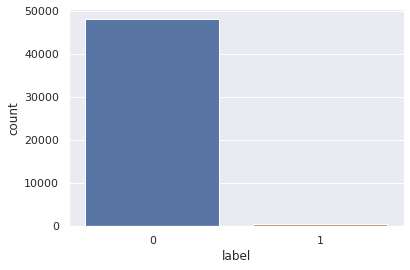

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.countplot(voice.label)
plt.show()

In [ ]:
#voice dataframe의 text에 word_length를 계산하여 word_length column에 글자수 계산하여 넣음
voice['word_length'] = voice['text'].apply(lambda x:len(x.split()))

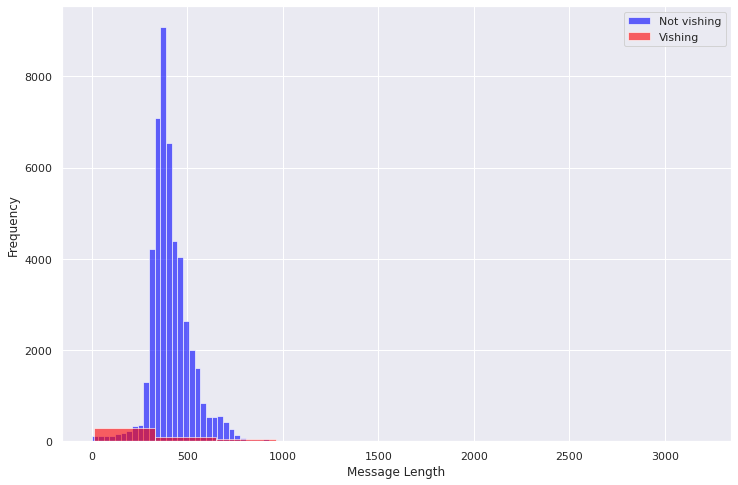

In [ ]:
plt.figure(figsize=(12, 8))

voice[voice.label==0].word_length.plot(bins=35, kind='hist', color='blue',
                                      label="Not vishing", alpha=0.6)
voice[voice.label==1].word_length.plot(kind='hist', color='red',
                                      label="Vishing", alpha=0.6)

plt.legend()
plt.xlabel("Message Length")
plt.show()

In [ ]:
voice.groupby('label').mean()
# 길이가 너무 길어 LSTM은 힘들다.

,word_length
label,
0,410.803911
1,411.811280


In [ ]:
voice[voice.label == 0].describe()

,label,word_length
count,48126.0,48126.000000
mean,0.0,410.803911
std,0.0,106.128341
min,0.0,1.000000
25%,0.0,351.000000
50%,0.0,391.000000
75%,0.0,459.000000
max,0.0,1044.000000


In [ ]:
voice[voice.label == 1].describe()

,label,word_length
count,461.0,461.000000
mean,1.0,411.811280
std,0.0,517.519104
min,1.0,12.000000
25%,1.0,94.000000
50%,1.0,224.000000
75%,1.0,493.000000
max,1.0,3189.000000


In [ ]:
pre_X_train, pre_X_test, y_train, y_test = train_test_split(voice['text'], voice['label'], test_size=0.25, shuffle=True, random_state= 23)
# X : feature, 즉 여기선 텍스트를 의미 y : label 여기선 label을 의미
# train쪽 x를 x_train train쪽 y를 y_train이 됩니다
# test쪽 X를 X_test
# 
# 학습과 테스트 데이터로 나눔.

print("# split done")

# split done


In [ ]:
type(pre_X_train)

pandas.core.series.Series

In [ ]:
# 케라스 토크나이저: 훈련데이터에 대해서 토큰화와 정수 인코딩 과정을 수행함

tokenizer=Tokenizer()
tokenizer.fit_on_texts(pre_X_train)

In [ ]:
X_train_encoded = tokenizer.texts_to_sequences(pre_X_train) 

In [ ]:
word_to_index = tokenizer.word_index
# print(word_to_index, sep='\n')

In [ ]:
stop_words = list(stop_word_csv["stop_word"])

In [ ]:
# 문장을 단어들의 리스트로 변경
X_train=[]

for stc in pre_X_train:
  token=[]
  words=stc.split()
  for word in words:
    if word not in stop_words:
      token.append(word.lower())
  X_train.append(token)


X_test=[]

for stc in pre_X_test:
  token=[]
  words =stc.split()
  for word in words:
    if word not in stop_words:
      token.append(word.lower())
  X_test.append(token)

print("# tokenization done")

# tokenization done


단어인덱싱
-머신러닝에서 사용할수있도록 각 단어를 숫자로 변경

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer()
# Tokenizer() 불러와서 객체를 만듦


tokenizer.fit_on_texts(X_train)  
#X_train에 fitting함 
# fit_on_texts 문자데이터를 입력받아 리스트의 형태로 변환함

In [ ]:
print(tokenizer.word_counts)
# word_counts에 인덱싱한 총 단어가 있음 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(len(tokenizer.word_counts))

176626


In [ ]:
# 최소 2번이상 나온 단어만 카운딩 
# 없애는 것은 위험하다
count = 0 
for word, word_count in tokenizer.word_counts.items():
  if word_count > 1 :
    count +=1


print(count)

119365


In [ ]:
tokenizer = Tokenizer(120000)  
# 약 4000개 인덱싱 ----- ??????????

In [ ]:
tokenizer.fit_on_texts(X_train)
# tokenizerk X_train 내부의 4000개의 단어를 인덱싱 하도록 fitting함
# fit_on_texts 메소드로 단어 목록을 생성함

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = tokenizer.texts_to_sequences(X_train)
X_test =  tokenizer.texts_to_sequences(X_test)

#데이터에 대해 정수 인코딩을 진행함 
#X_train에 대해서만 fitting을 진행했기 때문에 X_test도 그 기준으로 인덱싱 됨 



# X_train과 X_test로 나누기 전에 전체 X에 대해 fitting을 시켜줘도 프로세스 상 큰 문제는 없다.



print("# int_encoding done")

# int_encoding done


import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)ㅇㅇㅇㅇㅇ22322131ㄴㅇㄹㅇㄴㄴㅇㄹㅇㄴㄹㄴㄴㅇㄹㄴㅇㄹㄴㄹ
    
    
    
    
    데이터 패딩

- 벡터의 크기가 다르면 원활한 진행을 할수 없어서 크기를 통일화 해줌 

-패딩결정, 임베딩 레이어로 넣을 벡터 길이를 정함
-해당 벡터길이는 최대길이나 평균길이 사용 
- 최대 - 데이터 손실은 없으나 효율 떨어짐
-최소 - 데이터 손실은 있으나 효율이 좋음 

In [ ]:
max_len = 450
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)


#pad_sequences 이용해서 max_len 값만큼 데이터를 늘리거나 줄인다 (늘릴경우 0으로 채운다)
# 여기서는 최대길이를 평균길이 사이 정도의 값을 선택

모델구축


In [ ]:
# 모델 구축
#레이어들을 쌓을 모델 생성

model = Sequential()

# 지금까지 구축한 데이터가 Embedding에 들어가 워드 임베딩화 됨 / 4000개의 단어를 32차원으로 보낸다
model.add(Embedding(120000,32))

# 임베딩회된 데이터가 LSTM을 통하서 특정값을 도출함 / 입력은 32차원으로 보내온 임베딩 데이터
model.add(LSTM(32))

# sigmoid함수에 통과시켜서 최종값을 얻음
model.add(Dense(1, activation='sigmoid'))

최적모델 찾기


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 케라스홀백 함수 
# EarlyStopping, ModelCheckpoint

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose =1 , patience = 5)

# EarlyStopping : epoch를 정하는데 사용됨  / 무조건 많은 epoch를 돌린후 특정 시점에 멈춤
# monitor = 'val_loss' 
# mode = 'min'  performance measure가 최소화 시켜야 하는것이면 mode를 mind으로 / 최대화는 max로 / loss는 최소화 시켜야 해서 min
# verbose =1 언제 keras 에서 training 을 멈추었는지를 화면에 출력
# patience = 5 /// patience는 성능이 증가하지 않는 epoch를 몇번 허용할것인가를 정의함 / 주관적인기준


In [ ]:
model_check = ModelCheckpoint('the_best.h5', moniter = 'val_acc', mode= 'max', verbose=1, save_best_only = True)

# 가장 validation performance 가 좋은 모델을 저장하는 것이 필요한데, keras 에서는 이를 위해 ModelCheckpoint 라고 하는 객체를 존재
# model의 weight값을 중간에 저장해 줌 

# validation error 를 모니터링하면서, 이전 epoch 에 비해 validation performance 가 좋은 경우, 무조건 이 때의 parameter 들을 저장


# 이를 통해 트레이닝이 중지되었을 때, 가장 validation performance 가 높았던 모델을 반환


# 'the_best.h5 파일명 지정
# moniter = 'val_acc'  val_acc값이 개선되었을때 호출
# save_best_only = True 가장 best 값만 저장 

모델학습

In [ ]:
#에포크 바꿔가면서 해보기
#overfitting 방지: batch normalization, 

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['acc'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=64, callbacks = [early_stop, model_check])

# loss = 'binary_crossentropy' 손실함수는 binary_crossentropy선택
# optimizer = 'adam' 최적화 방법은 adam 으로 선택
# metrics=['acc']  평가기준은 정확도로 함 


#  validation_data에는 검증 데이터가 들어감 
# callback은 변수 넣어둠 

570/570 [==============================] - ETA: 0s - loss: 0.0610 - acc: 0.9900
Epoch 1: val_loss improved from -inf to 0.01513, saving model to the_best.h5
570/570 [==============================] - 165s 285ms/step - loss: 0.0610 - acc: 0.9900 - val_loss: 0.0151 - val_acc: 0.9934


In [ ]:
# 정확도 측정
print(model.evaluate(X_test, y_test))

380/380 [==============================] - 14s 37ms/step - loss: 0.0151 - acc: 0.9934
[0.015133334323763847, 0.9934139847755432]


In [ ]:
user_input = input().split()

user_data = [[]]
for word in user_input:
  spell_check(word)
  if word not in stop_words:
    user_data[0].append(word.lower())

user_data = tokenizer.texts_to_sequences(user_data)
user_data = pad_sequences(user_data, maxlen=max_len)
       
if (model.predict(user_data)>0.5):
  print('이것은 보이스피싱입니다')
  print(model.predict(user_data))
else:
  print('이것은 보이스피싱이 아닙니다')
  print(model.predict(user_data)) 
    


광주 태생 마 소생 남석인데 김남석이라는 분 혹시 아시는 분인가요 김남석이요 김영석이요 염석이요 김명석여 몰라요 예전에 농협 은행권에서 10여 년 정도 과장 근무로 근무했던 사람인데 전혀 모르시는 건가요 네 저는 아예 모르는 사람인데 아 그래요 그러면 본인 통장을 양도나 판매하신 적이 있나요. 아니요. 솔직하게 말씀해 주셔야 되고요 저희가 얼마 전에 수사가로부터 김명석 금융 범죄 사기단체를 검거를 했습니다. 검거 당시 현장에서 신분증 대포통장 보안 수사 이런 걸 대장으로 저 예전에 목포에서 아예 지갑채를 잃어버린 적이 있었거든요. 예예 그리고 제가 이제 말씀을 드리겠는데 네 2018년 8월 2일 3월 2일 경기도 광명시 부근에서 이 통장이 발급된 사실이 확인이 되었는데 본인이 거기서 직접 발급받으신 게 맞으신가요 저는 광명에 가본 적이 없는데요. 그러면 3월 2일 그때 당시 본인 어디에 계셨는지 기억나시는 게 있으면 설명 좀 해 주시겠어요. 3월 1일이요 3일 전 3월 2일 2일이요 잠시만요 제가 친구하고 연락한 거 있나 한번 봐볼게요 아 예예 잠시만요 제가 혹시 다시 찾아보고 바로 전화드려도 되나요. 지금 목록이 너무 많아서 그리고 저희가 이제 김병석의 진술에 따르면 본인을 알고 있다고 이렇게 진술했는데요. 저는 그런 사람 김명석도 모르고 영석도 모르고 다 몰라요 진짜 네 그리고 본인을 포함해서 다수 매의자로부터 통장을 100만 원에서 200만 원가량 금전적인 대가를 지불을 하고 양도를 받았다고 이렇게 진술했습니다. 돈도 없는데 저 왜 예 지금 금감원에서 합동 수사를 하고 있는데 본인이 지금 현재 사용하고 계신 은행권이 있으시면 상호 명만 간단하게 말씀을 해 주세요. 우리은행하고 국민은행 거 있어요. 이 은행의 용도는 지금 어떤 용도로 계좌를 해서 지금 사용하고 계신 건지 예를 들면 입출금 예금 청약 접금 이런 식으로 사용하고 있는 거 있나요. 그냥 입출금하고 원래 회사 다닐 때 월급 통장으로 썼었어요. 그리고 적금이나 청약 이런 상품들은 없으시고요 네 적금

In [ ]:
# # from keras.models import load_model
# model.save('text_lstm_model.h5')

print(voice["text"][2])

대검찰청 첨단범죄수사과입니다 다름이 아니라 사건 수사 중에 본인하고 연루된 부분이 있으면 확인차 연락드리겠습니다 혹시 최영식이라는 사람 간에 어떤 사이십니까 최영식이요 최자 영자 식 자이십니다 모르는데요 누군지 왜냐하면 저희 수사팀에서 최용식 주범으로부터 여러 명 금융 사기범을 검거하셨습니다 그들이 거주지에서 대량의 차명계좌를 압수했는데요 불법 자드리 거주지에서 대량의 차명 계좌를 압수했는데요 그중에 보시게 되면 본인의 명의로 신청되어 있는 농협하고 신한은행 통장에 수색이 되었습니다 내 이름으로 농협하고 편한데 통장이요 제 이름으로 차명 계좌가 있다고요 그러시고 지난 삼십 일 동안 보시게 되면 선생님 여기가 또 이쪽 통장 세탁이 되었고요 본인이 명의가 된 이 두 통장으로부터 약 1억 6천만 불고 돈이 세탁이 된 상황이시고요 현재 이 불법 기사로부터 돈 세탁이 한 상황이라면 상황이시라고요 지금 불법 세탁이 돈 세탁을 어떻게 해요 돈 세탁 돈 세탁을 어떻게 하시겠습니까 돈을 해보세요 뺐다가 줬다 하는 건 돈 세탁이라고 하시는 거 통장으로 통장 거래가 놨는데 그게 세탁이 돼요 현재 이미 세탁이 되었습니다 불법 단위 이주 통으로 세탁이 된 상황입니다 최근에 통장을 판매하는 파면 계좌를 개설해 줬습니까 아니요 그런데 최영 씨는 이 불법 단체로부터 받으시면 그 통장을 본인이 앞으로 구매한 통장이라 하시는데 정말 모르는 사람이십니다 중간 번호를 알려주세요 통장 번호를 알려달라고 내가 그런 통장을 만든 적이 있는지를 확인해야 되니까 통장은 농협 뒷다리 보시게 되면 하나하나 공사를 있습니다 그게 온라인 뱅킹으로 됐어요 아니면은 온라인 뱅킹으로 통장이 출금이 됐어요 아니면 직접 가서 인출금을 했어요 인출금을 했단 말이지 이틀 근무한 게 온라인 뱅킹으로 했는지 내가 직접 가서 한 건지 확인 좀 해주세요 근데 본인께서 하는 거 아니지는 불법 자드 손에서 돈 세탁을 했다는 사용됐단 말씀이십니다 지금 그러니까 누가 그걸 했는지 온라인 뱅킹으로 했다 그러면 불법 단체로부터 이쪽을 사용하

In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:

def spell_check(input):
    input_convert = input.replace('.', '.#').split('#') #문장 단위로 분리
    input_list = [""]
    for i in input_convert:
        if (len(input_list[-1]) + len(i)) < 500:
            input_list[-1] += i
        else:
            input_list.append(i)
    result = spell_checker.check(input_list)
    result = ''
    for j, k in enumerate(input_list):
        a = spell_checker.check([input_list[j]])
        a = a[0].checked
        result = result + a
    return result

In [ ]:
spell_check("안녕하셍용 최우영입뉘다")

'안녕하셍용 최우영입니다'